In [36]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


In [14]:
df = pd.read_csv('kag_risk_factors_cervical_cancer.csv')
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [15]:
# replace ? with NaN
df = df.replace('?', np.nan)

In [16]:
#these columns are not of type object, but are of type numeric
cols_to_convert = ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes',
                   'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives',
                   'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)',
                   'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
                   'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                   'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B',
                   'STDs:HPV', 'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis']
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors="coerce")
df[cols_to_convert].fillna(np.nan, inplace=True)

C:\Users\jran8\AppData\Local\Temp\ipykernel_126076\1582471216.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols_to_convert].fillna(np.nan, inplace=True)


In [17]:
# missing value imputation
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(df)
df = pd.DataFrame(X, columns=list(df.columns))

In [19]:
std_cols = {'STDs:condylomatosis',
            'STDs:cervical condylomatosis',
            'STDs:vaginal condylomatosis',
            'STDs:vulvo-perineal condylomatosis',
            'STDs:syphilis',
            'STDs:pelvic inflammatory disease',
            'STDs:genital herpes',
            'STDs:molluscum contagiosum',
            'STDs:AIDS',
            'STDs:HIV',
            'STDs:Hepatitis B',
            'STDs:HPV'}

df["total_std"] = df[list(std_cols)].sum(axis=1)

test_cols = ["Hinselmann", "Schiller", "Citology", "Biopsy"]
df["total_tests"] = df[test_cols].sum(axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    float64
 1   Number of sexual partners           858 non-null    float64
 2   First sexual intercourse            858 non-null    float64
 3   Num of pregnancies                  858 non-null    float64
 4   Smokes                              858 non-null    float64
 5   Smokes (years)                      858 non-null    float64
 6   Smokes (packs/year)                 858 non-null    float64
 7   Hormonal Contraceptives             858 non-null    float64
 8   Hormonal Contraceptives (years)     858 non-null    float64
 9   IUD                                 858 non-null    float64
 10  IUD (years)                         858 non-null    float64
 11  STDs                                858 non-n

In [20]:
to_int_and_beyond = {"total_tests",
                     "total_std",
                     "Smokes",
                     "Biopsy",
                     "Dx:Cancer",
                     "Num of pregnancies",
                     "Number of sexual partners",
                     "First sexual intercourse",
                     "Hormonal Contraceptives",
                     "IUD",
                     "STDs",
                     "STDs (number)",
                     "STDs: Number of diagnosis",
                     "Dx:CIN",
                     "Dx:HPV",
                     "Dx",
                     "Hinselmann",
                     "Schiller",
                     "Biopsy",
                     "Citology"}

to_int_and_beyond = to_int_and_beyond.union(std_cols)

for col in to_int_and_beyond:
    df[col] = df[col].astype('Int64')

In [21]:
df.rename({
           'Age': 'age', 
           'Number of sexual partners': 'num_sex_partners',
           'First sexual intercourse': 'first_sex',
           'Num of pregnancies': 'num_preg',
           'Smokes': 'smoker',
           'Smokes (years)': 'smoke_years',
           'Smokes (packs/year)': 'pack_years',
           'Hormonal Contraceptives': 'contracept', 
           'Hormonal Contraceptives (years)': 'contracept_years',
           'IUD': 'iud',
           'IUD (years)': 'iud_years',
           'STDs': 'stds',
           'STDs (number)': 'stds_num',
           'STDs:condylomatosis': 'std_condy', 
           'STDs:cervical condylomatosis': 'std_cerv_condy',
           'STDs:vaginal condylomatosis': 'std_vag_condy',
           'STDs:vulvo-perineal condylomatosis': 'std_vulvperi_condy',
           'STDs:syphilis': 'std_syphilis',
           'STDs:pelvic inflammatory disease': 'std_pid',
           'STDs:genital herpes': 'std_herpes',
           'STDs:molluscum contagiosum': 'std_molluscum', 
           'STDs:AIDS': 'std_aids',
           'STDs:HIV': 'std_hiv',
           'STDs:Hepatitis B': 'std_hep_b',
           'STDs:HPV': 'std_hpv',
           'STDs: Number of diagnosis': 'std_num_dx',
           'STDs: Time since first diagnosis': 'std_time_first_dx',
           'STDs: Time since last diagnosis': 'std_time_last_dx',
           'Dx:Cancer': 'cancer', 
           'Dx:CIN': 'cin', 
           'Dx:HPV': 'hpv', 
           'Dx': 'dx', 
           'Hinselmann': 'hinselmann',
           'Schiller': 'schiller', 
           'Citology': 'cytology',
           'Biopsy': 'biopsy'
           }, 
          axis=1, 
          inplace=True)

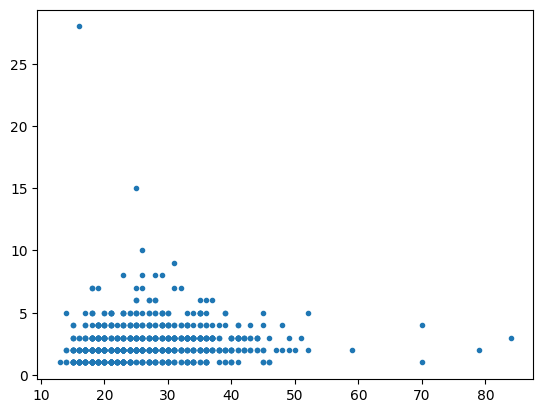

In [22]:
plt.plot(np.array(df['age']),np.array(df['num_sex_partners']),'.')

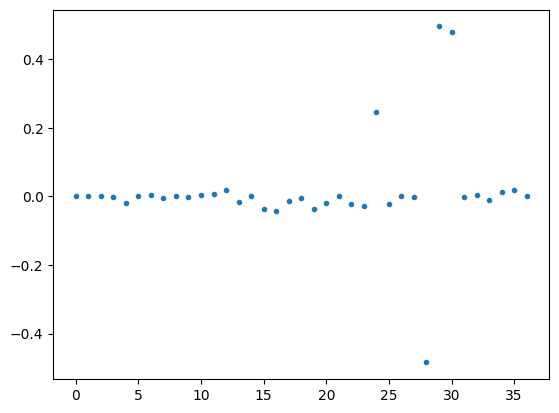

In [40]:
# trying linear regression to see which features contribute most
X = df.drop(['cancer'],axis=1)
Y = df['cancer']
y = Y.astype('int')

reg = LinearRegression()
reg.fit(X,Y)
plt.plot(reg.coef_,'.')

In [41]:
cdf = pd.DataFrame(reg.coef_, X.columns, columns=['Coefficients'])
print(cdf)

                    Coefficients
age                 1.645995e-05
num_sex_partners   -1.872832e-04
first_sex           5.255656e-04
num_preg           -1.193435e-03
smoker             -1.846863e-02
smoke_years         4.120197e-04
pack_years          5.200837e-03
contracept         -4.082141e-03
contracept_years    1.379691e-03
iud                -8.917354e-04
iud_years           2.494875e-03
stds                7.951483e-03
stds_num            1.776352e-02
std_condy          -1.635344e-02
std_cerv_condy      5.551115e-17
std_vag_condy      -3.842618e-02
std_vulvperi_condy -4.292014e-02
std_syphilis       -1.486864e-02
std_pid            -6.031613e-03
std_herpes         -3.710734e-02
std_molluscum      -1.979308e-02
std_aids            4.163336e-17
std_hiv            -2.165085e-02
std_hep_b          -2.962922e-02
std_hpv             2.445440e-01
std_num_dx         -2.298777e-02
std_time_first_dx   7.413459e-04
std_time_last_dx   -2.352562e-03
cin                -4.843077e-01
hpv       

In [42]:
# seems that the biggest linear components are only because they're rare and so is the cervical cancer diagnosis...
print(df['std_hpv'].value_counts())
print(df['cin'].value_counts())
print(df['hpv'].value_counts())
print(df['dx'].value_counts())
print(df['cancer'].value_counts())

0    856
1      2
Name: std_hpv, dtype: Int64
0    849
1      9
Name: cin, dtype: Int64
0    840
1     18
Name: hpv, dtype: Int64
0    834
1     24
Name: dx, dtype: Int64
0    840
1     18
Name: cancer, dtype: Int64


In [71]:
f_select = X.drop(columns=['smoker','smoke_years','contracept','iud','stds_num','std_condy','std_cerv_condy','std_vag_condy','std_vulvperi_condy','std_syphilis','std_pid','std_herpes','std_molluscum','std_aids','std_hiv','std_hep_b','std_hpv','std_num_dx','std_time_first_dx','std_time_last_dx','cin','hpv','hinselmann','schiller','cytology','biopsy','total_std','total_tests','dx'])
f_select = f_select.astype('float64')
f_select.head()

,age,num_sex_partners,first_sex,num_preg,pack_years,contracept_years,iud_years,stds
0,18.0,4.0,15.0,1.0,0.0,0.0,0.0,0.0
1,15.0,1.0,14.0,1.0,0.0,0.0,0.0,0.0
2,34.0,1.0,17.0,1.0,0.0,0.0,0.0,0.0
3,52.0,5.0,16.0,4.0,37.0,3.0,0.0,0.0
4,46.0,3.0,21.0,4.0,0.0,15.0,0.0,0.0


In [72]:
# SMOTE stuff
sm = SMOTE()
new_X, new_Y = sm.fit_resample(f_select,y)

0.963963963963964
[[  0 266]
 [  1 289]]


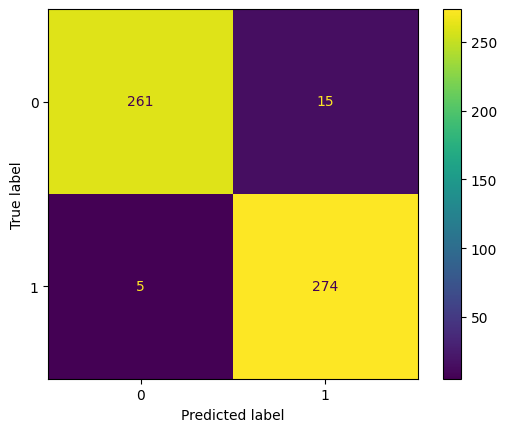

In [75]:
X_train, X_test, y_train, y_test = train_test_split(new_X, new_Y, test_size=0.33, random_state=1)
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)
print(accuracy_score(y_test,y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
print(np.asarray((unique, counts)).T)
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

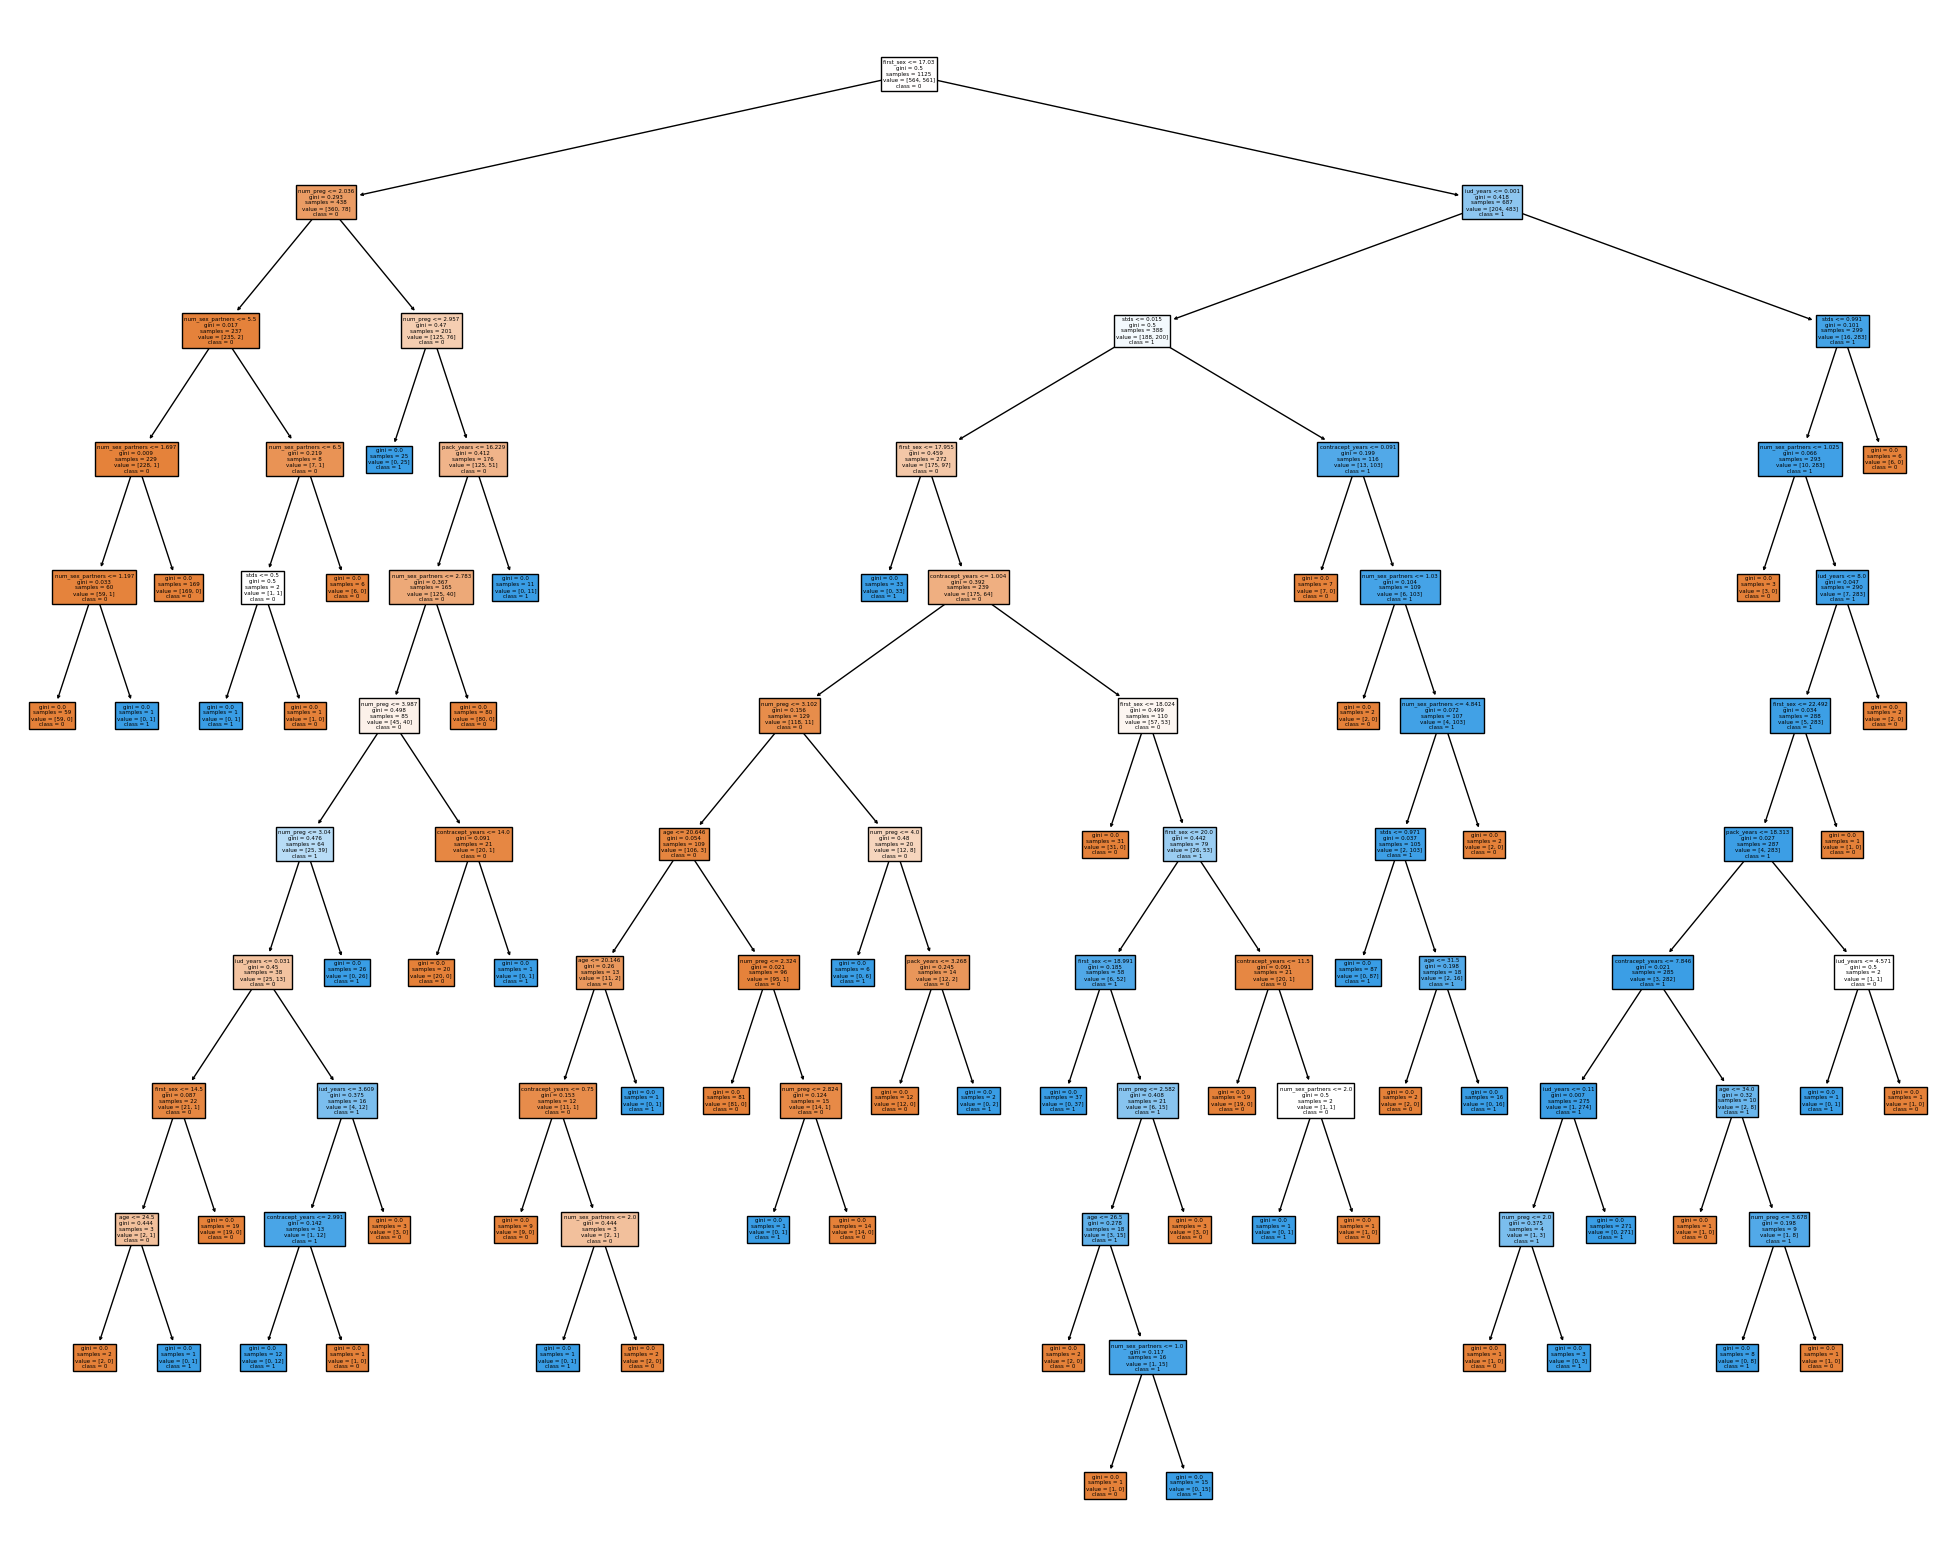

In [76]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(tree, 
                   feature_names=new_X.columns,  
                   class_names=['0','1'],
                   filled=True)

In [77]:
feature_imp = pd.Series(tree.feature_importances_,index=new_X.columns).sort_values(ascending=False)
feature_imp

first_sex           0.400868
num_preg            0.168609
iud_years           0.144754
stds                0.103557
num_sex_partners    0.068443
contracept_years    0.064568
pack_years          0.028831
age                 0.020371
dtype: float64

0.9783783783783784


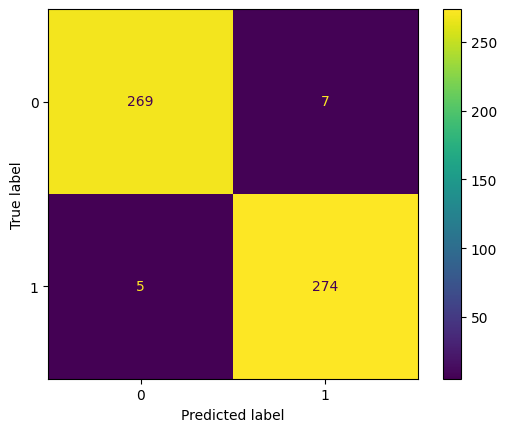

In [78]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
f_pred = forest.predict(X_test)
print(accuracy_score(y_test,f_pred))
cm = confusion_matrix(y_test,f_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

0.9855855855855856


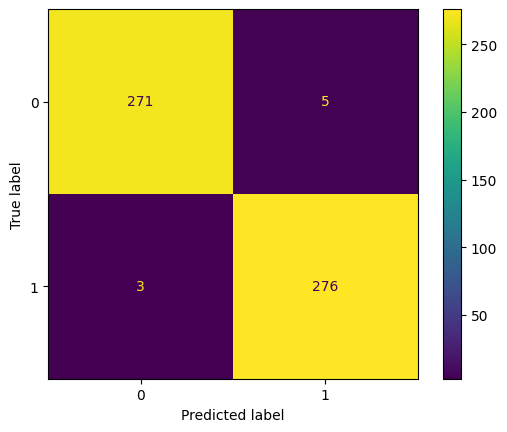

In [79]:
xgb = XGBClassifier(objective="binary:logistic",random_state=1)
xgb.fit(X_train,y_train)
x_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test,x_pred)
print(accuracy_score(y_test,x_pred))
cm_display = ConfusionMatrixDisplay(cm).plot()

In [112]:
sample = pd.DataFrame(data = {'age':[30],'num_sex_partners':[8],'first_sex':[17],'num_preg':[1],'pack_years':[4],'contracept_years':[7],'iud_years':[0],'stds':[0]})
sample.head()
xgb.predict_proba(sample)

array([[0.97197896, 0.02802103]], dtype=float32)